In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [27]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids='0006', xarray_dir='../data/NAFLD')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-10-31_head10.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/mask.nc
100%|██████████| 1/1 [00:00<00:00, 53.86it/s]


In [28]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [29]:
%autoreload

pino = mre_pinn.model.SpectralTransformer(
    n_spatial_dims=3,
    n_channels_in=4,
    n_channels_out=1,
    n_spatial_freqs=1024,
    n_channels_model=32,
    n_conv_blocks=2,
    n_spectral_blocks=0,
    activ_fn='g',
    omega=15/300
)
pino

SpectralTransformer(
  (spectral_fwd): SpectralTransform(
    (a_linear): Linear(in_features=4, out_features=32, bias=True)
    (conv_block1): ConvBlock(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
    )
    (conv_block2): ConvBlock(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
    )
    (x_linear): Linear(in_features=3, out_features=1024, bias=True)
  )
  (spectral_inv): SpectralInverse(
    (y_linear): Linear(in_features=3, out_features=1024, bias=True)
    (tconv_block1): TConvBlock(
      (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
      (tconv): ConvTranspose3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (upsample): Upsample(scale_factor=2.0, mode=nearest)
    )
    (tconv_block2): TConvBlock(
      (pool): AvgPool3d(kernel_size=2, stri

In [30]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-8, 1e0],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000251 s



Training model...

0         [5.56e-04, 5.56e+04]    [5.56e-04, 5.56e+04]    []  


<IPython.core.display.Javascript object>


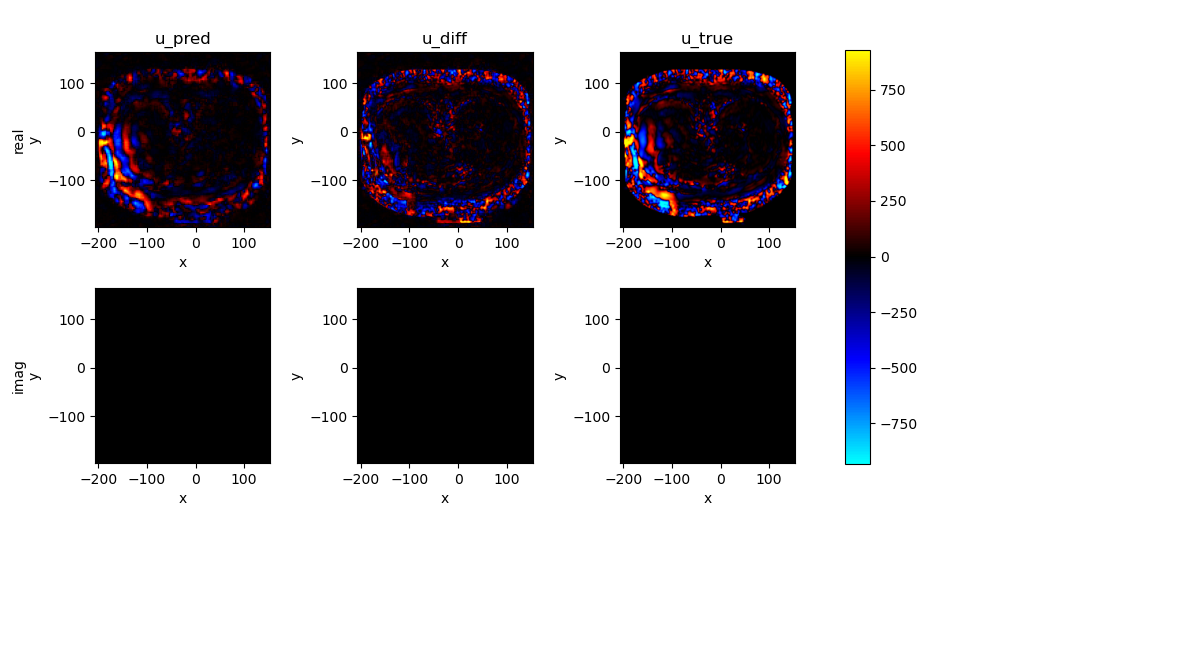

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

Time spent testing: 20.02%
10        [4.82e-04, 4.82e+04]    [4.82e-04, 4.82e+04]    []  
Time spent testing: 18.13%
20        [4.28e-04, 4.28e+04]    [4.28e-04, 4.28e+04]    []  
Time spent testing: 17.41%
30        [3.79e-04, 3.79e+04]    [3.79e-04, 3.79e+04]    []  
Time spent testing: 17.04%
40        [3.61e-04, 3.61e+04]    [3.61e-04, 3.61e+04]    []  
Time spent testing: 16.82%
50        [3.41e-04, 3.41e+04]    [3.41e-04, 3.41e+04]    []  
Time spent testing: 16.67%
60        [3.48e-04, 3.48e+04]    [3.48e-04, 3.48e+04]    []  
Time spent testing: 16.55%
70        [3.30e-04, 3.30e+04]    [3.30e-04, 3.30e+04]    []  
Time spent testing: 16.49%
80        [3.29e-04, 3.29e+04]    [3.29e-04, 3.29e+04]    []  
Time spent testing: 16.42%
90        [3.22e-04, 3.22e+04]    [3.22e-04, 3.22e+04]    []  
Time spent testing: 16.39%
100       [3.19e-04, 3.19e+04]    [3.19e-04, 3.19e+04]    []  
Time spent testing: 16.37%
110       [3.10e-04, 3.10e+04]    [3.10e-04, 3.10e+04]    []  
Time spent

920       [2.71e-04, 2.71e+04]    [2.71e-04, 2.71e+04]    []  
Time spent testing: 15.99%
930       [2.61e-04, 2.61e+04]    [2.61e-04, 2.61e+04]    []  
Time spent testing: 15.99%
940       [2.58e-04, 2.58e+04]    [2.58e-04, 2.58e+04]    []  
Time spent testing: 15.99%
950       [2.59e-04, 2.59e+04]    [2.59e-04, 2.59e+04]    []  
Time spent testing: 15.99%
960       [2.57e-04, 2.57e+04]    [2.57e-04, 2.57e+04]    []  
Time spent testing: 15.99%
970       [2.66e-04, 2.66e+04]    [2.66e-04, 2.66e+04]    []  
Time spent testing: 15.99%
980       [2.61e-04, 2.61e+04]    [2.61e-04, 2.61e+04]    []  
Time spent testing: 15.98%
990       [2.56e-04, 2.56e+04]    [2.56e-04, 2.56e+04]    []  
Time spent testing: 15.98%
1000      [2.67e-04, 2.67e+04]    [2.67e-04, 2.67e+04]    []  
Time spent testing: 15.98%
1010      [2.61e-04, 2.61e+04]    [2.61e-04, 2.61e+04]    []  
Time spent testing: 15.98%
1020      [2.60e-04, 2.60e+04]    [2.60e-04, 2.60e+04]    []  
Time spent testing: 15.98%
1030      

Time spent testing: 16.03%
1840      [2.57e-04, 2.57e+04]    [2.57e-04, 2.57e+04]    []  
Time spent testing: 16.03%
1850      [2.60e-04, 2.60e+04]    [2.60e-04, 2.60e+04]    []  
Time spent testing: 16.03%
1860      [2.53e-04, 2.53e+04]    [2.53e-04, 2.53e+04]    []  
Time spent testing: 16.03%
1870      [2.52e-04, 2.52e+04]    [2.52e-04, 2.52e+04]    []  
Time spent testing: 16.03%
1880      [2.54e-04, 2.54e+04]    [2.54e-04, 2.54e+04]    []  
Time spent testing: 16.03%
1890      [2.51e-04, 2.51e+04]    [2.51e-04, 2.51e+04]    []  
Time spent testing: 16.03%
1900      [2.50e-04, 2.50e+04]    [2.50e-04, 2.50e+04]    []  
Time spent testing: 16.03%
1910      [2.53e-04, 2.53e+04]    [2.53e-04, 2.53e+04]    []  
Time spent testing: 16.03%
1920      [2.51e-04, 2.51e+04]    [2.51e-04, 2.51e+04]    []  
Time spent testing: 16.03%
1930      [2.51e-04, 2.51e+04]    [2.51e-04, 2.51e+04]    []  
Time spent testing: 16.03%
1940      [2.48e-04, 2.48e+04]    [2.48e-04, 2.48e+04]    []  
Time spent

2750      [2.52e-04, 2.52e+04]    [2.52e-04, 2.52e+04]    []  
Time spent testing: 16.04%
2760      [2.48e-04, 2.48e+04]    [2.48e-04, 2.48e+04]    []  
Time spent testing: 16.04%
2770      [2.48e-04, 2.48e+04]    [2.48e-04, 2.48e+04]    []  
Time spent testing: 16.04%
2780      [2.49e-04, 2.49e+04]    [2.49e-04, 2.49e+04]    []  
Time spent testing: 16.04%
2790      [2.47e-04, 2.47e+04]    [2.47e-04, 2.47e+04]    []  
Time spent testing: 16.04%
2800      [2.48e-04, 2.48e+04]    [2.48e-04, 2.48e+04]    []  
Time spent testing: 16.04%
2810      [2.50e-04, 2.50e+04]    [2.50e-04, 2.50e+04]    []  
Time spent testing: 16.04%
2820      [2.52e-04, 2.52e+04]    [2.52e-04, 2.52e+04]    []  
Time spent testing: 16.04%
2830      [2.49e-04, 2.49e+04]    [2.49e-04, 2.49e+04]    []  
Time spent testing: 16.04%
2840      [2.48e-04, 2.48e+04]    [2.48e-04, 2.48e+04]    []  
Time spent testing: 16.04%
2850      [2.48e-04, 2.48e+04]    [2.48e-04, 2.48e+04]    []  
Time spent testing: 16.04%
2860      

Time spent testing: 16.03%
3670      [2.48e-04, 2.48e+04]    [2.48e-04, 2.48e+04]    []  
Time spent testing: 16.03%
3680      [2.46e-04, 2.46e+04]    [2.46e-04, 2.46e+04]    []  
Time spent testing: 16.03%
3690      [2.49e-04, 2.49e+04]    [2.49e-04, 2.49e+04]    []  
Time spent testing: 16.03%
3700      [2.49e-04, 2.49e+04]    [2.49e-04, 2.49e+04]    []  
Time spent testing: 16.03%
3710      [2.47e-04, 2.47e+04]    [2.47e-04, 2.47e+04]    []  
Time spent testing: 16.03%
3720      [2.52e-04, 2.52e+04]    [2.52e-04, 2.52e+04]    []  
Time spent testing: 16.03%
3730      [2.60e-04, 2.60e+04]    [2.60e-04, 2.60e+04]    []  
Time spent testing: 16.03%
3740      [2.51e-04, 2.51e+04]    [2.51e-04, 2.51e+04]    []  
Time spent testing: 16.03%
3750      [2.54e-04, 2.54e+04]    [2.54e-04, 2.54e+04]    []  
Time spent testing: 16.03%
3760      [2.51e-04, 2.51e+04]    [2.51e-04, 2.51e+04]    []  
Time spent testing: 16.03%
3770      [2.46e-04, 2.46e+04]    [2.46e-04, 2.46e+04]    []  
Time spent

4580      [2.49e-04, 2.49e+04]    [2.49e-04, 2.49e+04]    []  
Time spent testing: 16.04%
4590      [2.46e-04, 2.46e+04]    [2.46e-04, 2.46e+04]    []  
Time spent testing: 16.04%
4600      [2.45e-04, 2.45e+04]    [2.45e-04, 2.45e+04]    []  
Time spent testing: 16.04%
4610      [2.49e-04, 2.49e+04]    [2.49e-04, 2.49e+04]    []  
Time spent testing: 16.03%
4620      [2.47e-04, 2.47e+04]    [2.47e-04, 2.47e+04]    []  
Time spent testing: 16.03%
4630      [2.45e-04, 2.45e+04]    [2.45e-04, 2.45e+04]    []  
Time spent testing: 16.03%
4640      [2.45e-04, 2.45e+04]    [2.45e-04, 2.45e+04]    []  
Time spent testing: 16.03%
4650      [2.45e-04, 2.45e+04]    [2.45e-04, 2.45e+04]    []  
Time spent testing: 16.03%
4660      [2.49e-04, 2.49e+04]    [2.49e-04, 2.49e+04]    []  
Time spent testing: 16.03%
4670      [2.82e-04, 2.82e+04]    [2.82e-04, 2.82e+04]    []  
Time spent testing: 16.03%
4680      [2.72e-04, 2.72e+04]    [2.72e-04, 2.72e+04]    []  
Time spent testing: 16.03%
4690      

Time spent testing: 16.04%
5500      [2.49e-04, 2.49e+04]    [2.49e-04, 2.49e+04]    []  
Time spent testing: 16.04%
5510      [2.45e-04, 2.45e+04]    [2.45e-04, 2.45e+04]    []  
Time spent testing: 16.04%
5520      [2.47e-04, 2.47e+04]    [2.47e-04, 2.47e+04]    []  
Time spent testing: 16.04%
5530      [2.45e-04, 2.45e+04]    [2.45e-04, 2.45e+04]    []  
Time spent testing: 16.04%
5540      [2.43e-04, 2.43e+04]    [2.43e-04, 2.43e+04]    []  
Time spent testing: 16.04%
5550      [2.51e-04, 2.51e+04]    [2.51e-04, 2.51e+04]    []  
Time spent testing: 16.04%
5560      [2.53e-04, 2.53e+04]    [2.53e-04, 2.53e+04]    []  
Time spent testing: 16.04%
5570      [2.46e-04, 2.46e+04]    [2.46e-04, 2.46e+04]    []  
Time spent testing: 16.04%
5580      [2.44e-04, 2.44e+04]    [2.44e-04, 2.44e+04]    []  
Time spent testing: 16.04%
5590      [2.45e-04, 2.45e+04]    [2.45e-04, 2.45e+04]    []  
Time spent testing: 16.04%
5600      [2.45e-04, 2.45e+04]    [2.45e-04, 2.45e+04]    []  
Time spent

In [ ]:
model.train(10000, display_every=10, callbacks=[test_eval])